# Fleet engine health analytics

### Load data

In [45]:
import pandas as pd

In [46]:
# Column names based on NASA documentation
columns = [
    "engine_id", "cycle",
    "op_setting_1", "op_setting_2", "op_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]

In [47]:
# Load training data
train_df = pd.read_csv(
    "CMAPSSData/train_FD001.txt",
    sep=r"\s+",
    header=None,
    names=columns
)


In [48]:
# Remove empty columns (due to extra spaces)
train_df = train_df.dropna(axis=1)

train_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Sanity Check

In [49]:
# Shape of the data
train_df.shape


(20631, 26)

In [50]:
# Number of engines
train_df["engine_id"].nunique()


100

In [51]:
# Cycles per engine
train_df.groupby("engine_id")["cycle"].max().describe()


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64

In [52]:
import matplotlib.pyplot as plt


In [53]:
engine_example = train_df[train_df["engine_id"] == 1]

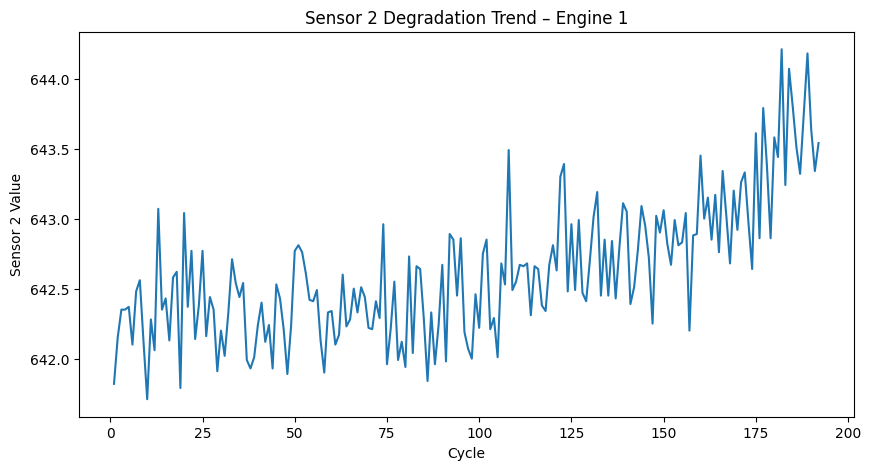

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(engine_example["cycle"], engine_example["sensor_2"])
plt.xlabel("Cycle")
plt.ylabel("Sensor 2 Value")
plt.title("Sensor 2 Degradation Trend – Engine 1")
plt.show()

This plot shows the raw time-series behavior of Sensor 2 for a single engine across its operational cycles. While short-term fluctuations are present due to sensor noise and operating variability, the overall upward trend indicates progressive degradation as the engine approaches failure. This confirms that individual sensors contain useful degradation information but require smoothing and aggregation for robust health assessment.

In [55]:
sensor_cols = [col for col in train_df.columns if col.startswith("sensor_")]

sensor_variance = train_df[sensor_cols].var().sort_values(ascending=False)
sensor_variance

sensor_9     4.876536e+02
sensor_14    3.639005e+02
sensor_4     8.101089e+01
sensor_3     3.759099e+01
sensor_17    2.398667e+00
sensor_7     7.833883e-01
sensor_12    5.439850e-01
sensor_2     2.500533e-01
sensor_11    7.133568e-02
sensor_20    3.266927e-02
sensor_21    1.171825e-02
sensor_13    5.172330e-03
sensor_8     5.038938e-03
sensor_15    1.406628e-03
sensor_6     1.929279e-06
sensor_5     3.155597e-30
sensor_16    1.926023e-34
sensor_10    0.000000e+00
sensor_18    0.000000e+00
sensor_19    0.000000e+00
sensor_1     0.000000e+00
dtype: float64

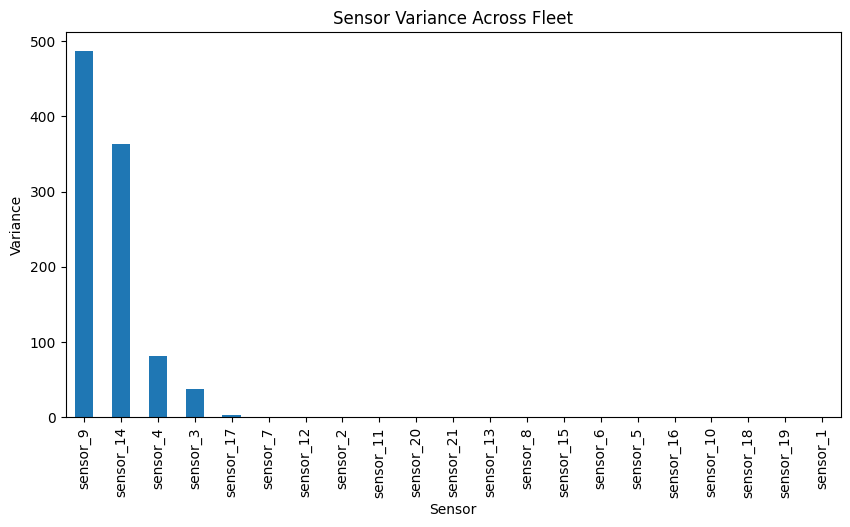

In [56]:
plt.figure(figsize=(10, 5))
sensor_variance.plot(kind="bar")
plt.title("Sensor Variance Across Fleet")
plt.ylabel("Variance")
plt.xlabel("Sensor")
plt.show()


This bar chart compares variance across all sensors at the fleet level. Sensors with higher variance exhibit greater sensitivity to engine degradation, while low-variance sensors contribute minimal information. Based on this analysis, low-variance sensors were excluded to reduce noise and improve feature quality. This step ensures that subsequent models focus on sensors most relevant to health monitoring.

In [57]:
sensor_variance[sensor_variance < 1e-5]

sensor_6     1.929279e-06
sensor_5     3.155597e-30
sensor_16    1.926023e-34
sensor_10    0.000000e+00
sensor_18    0.000000e+00
sensor_19    0.000000e+00
sensor_1     0.000000e+00
dtype: float64

In [58]:
useful_sensors = sensor_variance[sensor_variance >= 1e-5].index.tolist()

clean_df = train_df[
    ["engine_id", "cycle"] +
    ["op_setting_1", "op_setting_2", "op_setting_3"] +
    useful_sensors
]

clean_df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_9,sensor_14,sensor_4,sensor_3,sensor_17,sensor_7,sensor_12,sensor_2,sensor_11,sensor_20,sensor_21,sensor_13,sensor_8,sensor_15
0,1,1,-0.0007,-0.0004,100.0,9046.19,8138.62,1400.60,1589.70,392,554.36,521.66,641.82,47.47,39.06,23.4190,2388.02,2388.06,8.4195
1,1,2,0.0019,-0.0003,100.0,9044.07,8131.49,1403.14,1591.82,392,553.75,522.28,642.15,47.49,39.00,23.4236,2388.07,2388.04,8.4318
2,1,3,-0.0043,0.0003,100.0,9052.94,8133.23,1404.20,1587.99,390,554.26,522.42,642.35,47.27,38.95,23.3442,2388.03,2388.08,8.4178
3,1,4,0.0007,0.0000,100.0,9049.48,8133.83,1401.87,1582.79,392,554.45,522.86,642.35,47.13,38.88,23.3739,2388.08,2388.11,8.3682
4,1,5,-0.0019,-0.0002,100.0,9055.15,8133.80,1406.22,1582.85,393,554.00,522.19,642.37,47.28,38.90,23.4044,2388.04,2388.06,8.4294


In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

normalized_sensors = scaler.fit_transform(clean_df[useful_sensors])

normalized_df = clean_df.copy()
normalized_df[useful_sensors] = normalized_sensors

normalized_df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_9,sensor_14,sensor_4,sensor_3,sensor_17,sensor_7,sensor_12,sensor_2,sensor_11,sensor_20,sensor_21,sensor_13,sensor_8,sensor_15
0,1,1,-0.0007,-0.0004,100.0,-0.862813,-0.269071,-0.925936,-0.134255,-0.781710,1.121141,0.334262,-1.721725,-0.266467,1.348493,1.194427,-1.058890,-0.516338,-0.603816
1,1,2,0.0019,-0.0003,100.0,-0.958818,-0.642845,-0.643726,0.211528,-0.781710,0.431930,1.174899,-1.061780,-0.191583,1.016528,1.236922,-0.363646,-0.798093,-0.275852
2,1,3,-0.0043,0.0003,100.0,-0.557139,-0.551629,-0.525953,-0.413166,-2.073094,1.008155,1.364721,-0.661813,-1.015303,0.739891,0.503423,-0.919841,-0.234584,-0.649144
3,1,4,0.0007,0.0000,100.0,-0.713826,-0.520176,-0.784831,-1.261314,-0.781710,1.222827,1.961302,-0.661813,-1.539489,0.352598,0.777792,-0.224597,0.188048,-1.971665
4,1,5,-0.0019,-0.0002,100.0,-0.457059,-0.521748,-0.301518,-1.251528,-0.136018,0.714393,1.052871,-0.621816,-0.977861,0.463253,1.059552,-0.780793,-0.516338,-0.339845


In [60]:
normalized_df[useful_sensors].describe().loc[["mean", "std"]]

,sensor_9,sensor_14,sensor_4,sensor_3,sensor_17,sensor_7,sensor_12,sensor_2,sensor_11,sensor_20,sensor_21,sensor_13,sensor_8,sensor_15
mean,-4.185765e-14,3.061075e-15,9.285169e-16,-4.959437e-14,1.666922e-14,-3.161641e-14,-1.199702e-13,6.410348e-14,-2.937089e-15,4.156146e-14,2.402296e-14,3.493855e-13,1.008249e-12,-3.244023e-14
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00


The normalized sensor data exhibit near-zero mean and unit standard deviation across all selected sensors, confirming successful z-score standardization. Minor numerical deviations are attributable to floating-point precision and do not impact analytical validity.

In [61]:
# Rolling mean per engine
window = 20

rolling_df = normalized_df.copy()

for sensor in useful_sensors:
    rolling_df[f"{sensor}_roll_mean"] = (
        rolling_df
        .groupby("engine_id")[sensor]
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

rolling_df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_9,sensor_14,sensor_4,sensor_3,sensor_17,...,sensor_17_roll_mean,sensor_7_roll_mean,sensor_12_roll_mean,sensor_2_roll_mean,sensor_11_roll_mean,sensor_20_roll_mean,sensor_21_roll_mean,sensor_13_roll_mean,sensor_8_roll_mean,sensor_15_roll_mean
0,1,1,-0.0007,-0.0004,100.0,-0.862813,-0.269071,-0.925936,-0.134255,-0.781710,...,-0.781710,1.121141,0.334262,-1.721725,-0.266467,1.348493,1.194427,-1.058890,-0.516338,-0.603816
1,1,2,0.0019,-0.0003,100.0,-0.958818,-0.642845,-0.643726,0.211528,-0.781710,...,-0.781710,0.776535,0.754581,-1.391753,-0.229025,1.182510,1.215675,-0.711268,-0.657216,-0.439834
2,1,3,-0.0043,0.0003,100.0,-0.557139,-0.551629,-0.525953,-0.413166,-2.073094,...,-1.212171,0.853742,0.957961,-1.148439,-0.491118,1.034970,0.978257,-0.780793,-0.516338,-0.509604
3,1,4,0.0007,0.0000,100.0,-0.713826,-0.520176,-0.784831,-1.261314,-0.781710,...,-1.104556,0.946013,1.208796,-1.026783,-0.753210,0.864377,0.928141,-0.641744,-0.340242,-0.875119
4,1,5,-0.0019,-0.0002,100.0,-0.457059,-0.521748,-0.301518,-1.251528,-0.136018,...,-0.910848,0.899689,1.177611,-0.945789,-0.798141,0.784153,0.954423,-0.669553,-0.375461,-0.768064


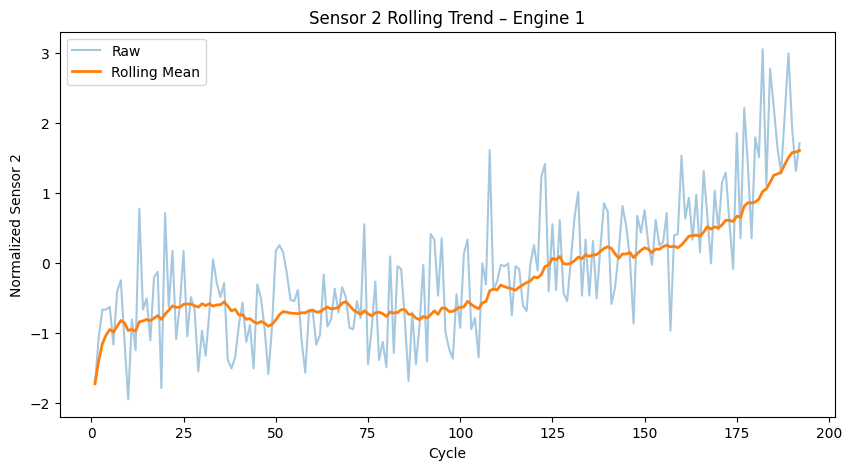

In [62]:
engine_example = rolling_df[rolling_df["engine_id"] == 1]

plt.figure(figsize=(10, 5))
plt.plot(engine_example["cycle"], engine_example["sensor_2"], alpha=0.4, label="Raw")
plt.plot(engine_example["cycle"], engine_example["sensor_2_roll_mean"], linewidth=2, label="Rolling Mean")
plt.legend()
plt.xlabel("Cycle")
plt.ylabel("Normalized Sensor 2")
plt.title("Sensor 2 Rolling Trend – Engine 1")
plt.show()


Applying a rolling mean smooths short-term fluctuations in Sensor 2 while preserving its long-term degradation pattern. The rolling trend clearly reveals the gradual shift from healthy operation to degradation, demonstrating the effectiveness of temporal smoothing in extracting meaningful health signals from noisy sensor data.

In [65]:
# Select rolling features only

roll_cols = [col for col in rolling_df.columns if col.endswith("_roll_mean")]
rolling_df["health_score"] = rolling_df[roll_cols].mean(axis=1)


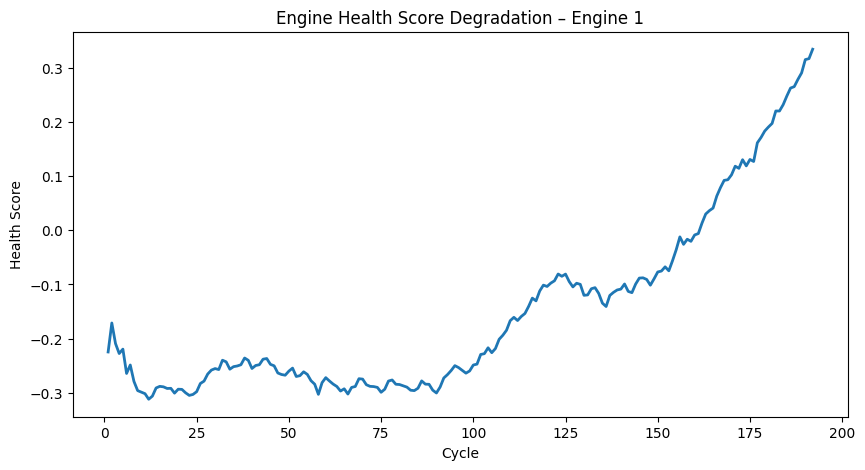

In [67]:
engine_example = rolling_df[rolling_df["engine_id"] == 1]

plt.figure(figsize=(10, 5))
plt.plot(engine_example["cycle"], engine_example["health_score"], linewidth=2)
plt.xlabel("Cycle")
plt.ylabel("Health Score")
plt.title("Engine Health Score Degradation – Engine 1")
plt.show()


The initial composite health score aggregates normalized sensor values into a single metric representing overall engine condition. Although the score captures degradation magnitude, its upward trend reflects mixed sensor behavior rather than intuitive health directionality. This motivated an inversion of the metric to improve interpretability.

In [68]:
# Convert to a Degradation Score

rolling_df["degradation_score"] = rolling_df[roll_cols].mean(axis=1)
rolling_df["health_score"] = -rolling_df["degradation_score"]


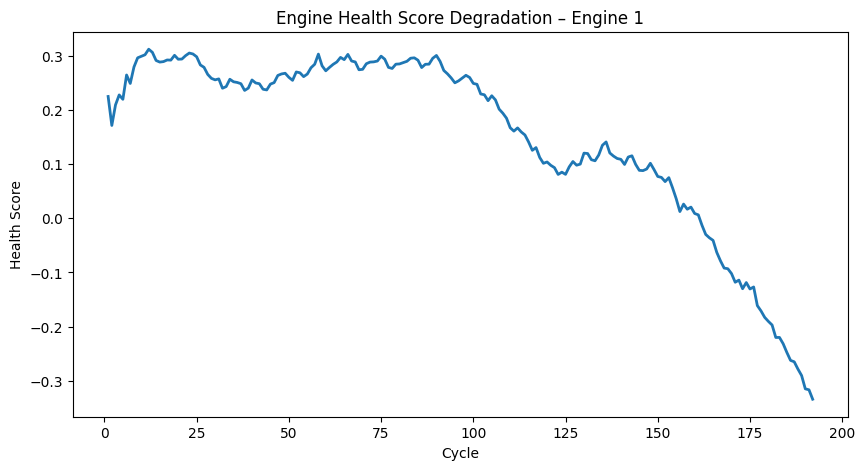

In [69]:
engine_example = rolling_df[rolling_df["engine_id"] == 1]

plt.figure(figsize=(10, 5))
plt.plot(engine_example["cycle"], engine_example["health_score"], linewidth=2)
plt.xlabel("Cycle")
plt.ylabel("Health Score")
plt.title("Engine Health Score Degradation – Engine 1")
plt.show()


After inversion, the health score exhibits a clear downward trend as engine condition deteriorates. Higher values represent healthier states, while declining values indicate increasing degradation. This transformed health score provides an intuitive and interpretable indicator of engine health over time.

In [70]:
# Final Health Score per Engine

final_health = (
    rolling_df
    .groupby("engine_id")
    .apply(lambda x: x.loc[x["cycle"].idxmax(), "health_score"])
    .reset_index(name="final_health_score")
)

final_health.head()


/var/folders/wj/zqspx8r57nn98fzn3y89drcw0000gn/T/ipykernel_49945/1091458120.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rolling_df


,engine_id,final_health_score
0,1,-0.333757
1,2,-0.603487
2,3,-0.945312
3,4,-1.032630
4,5,-0.871959


In [71]:
final_health["health_rank"] = final_health["final_health_score"].rank(ascending=True)

final_health.sort_values("health_rank").head(10)


,engine_id,final_health_score,health_rank
50,51,-1.228866,1.0
8,9,-1.164499,2.0
47,48,-1.160785,3.0
17,18,-1.125756,4.0
81,82,-1.099645,5.0
54,55,-1.059271,6.0
96,97,-1.039271,7.0
3,4,-1.032630,8.0
16,17,-0.968131,9.0
2,3,-0.945312,10.0


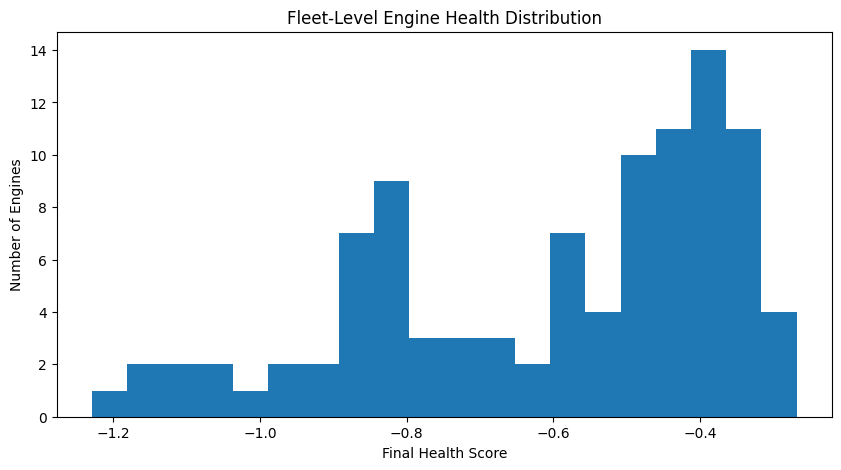

In [72]:
plt.figure(figsize=(10, 5))
plt.hist(final_health["final_health_score"], bins=20)
plt.xlabel("Final Health Score")
plt.ylabel("Number of Engines")
plt.title("Fleet-Level Engine Health Distribution")
plt.show()

This histogram shows the distribution of final health scores across the fleet. The spread indicates significant variability in engine condition at end-of-life, highlighting the importance of individualized monitoring rather than fixed maintenance intervals. Engines with lower final health scores may warrant earlier inspection or intervention.

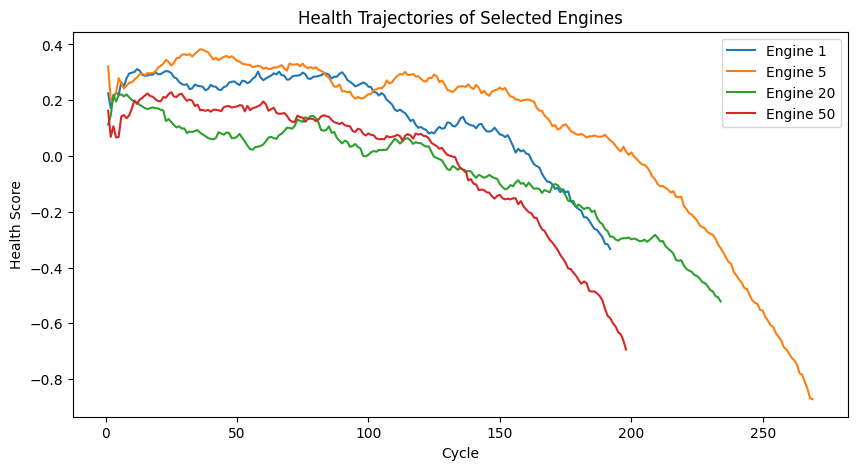

In [74]:
sample_engines = [1, 5, 20, 50]

plt.figure(figsize=(10, 5))
for eng in sample_engines:
    df_e = rolling_df[rolling_df["engine_id"] == eng]
    plt.plot(df_e["cycle"], df_e["health_score"], label=f"Engine {eng}")

plt.xlabel("Cycle")
plt.ylabel("Health Score")
plt.title("Health Trajectories of Selected Engines")
plt.legend()
plt.show()


This plot compares health score trajectories for multiple engines. Distinct degradation paths are observed, with some engines degrading gradually and others exhibiting rapid late-stage decline. These differences demonstrate the value of fleet-level analytics for prioritizing maintenance actions based on actual condition rather than usage alone.

#### Add RUL Labels (Ground Truth)

In [90]:
# Compute max cycle per engine
# Max cycle (failure point) per engine
max_cycles = rolling_df.groupby("engine_id")["cycle"].max()


In [91]:
# Compute Remaining Useful Life (RUL)
rolling_df["RUL"] = rolling_df.apply(
    lambda row: max_cycles[row["engine_id"]] - row["cycle"],
    axis=1
)

rolling_df[["engine_id", "cycle", "RUL"]].head()


,engine_id,cycle,RUL
0,1,1,191.0
1,1,2,190.0
2,1,3,189.0
3,1,4,188.0
4,1,5,187.0


#### Train a Regression Model (Baseline)

We’ll use a Random Forest:

- Works well with nonlinear degradation

- Minimal tuning

In [92]:
# Prepare features and target

# Use rolling sensor features only
X = rolling_df[roll_cols]
y = rolling_df["RUL"]


In [93]:
# Train / validation split
engine_ids = rolling_df["engine_id"].unique()
train_engines = engine_ids[:80]
test_engines = engine_ids[80:]

train_data = rolling_df[rolling_df["engine_id"].isin(train_engines)]
test_data = rolling_df[rolling_df["engine_id"].isin(test_engines)]

X_train = train_data[roll_cols]
y_train = train_data["RUL"]
X_test = test_data[roll_cols]
y_test = test_data["RUL"]



In [94]:
# Train model
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)



RandomForestRegressor(n_jobs=-1, random_state=42)

In [95]:
# Evaluate model

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse


(39.34267749833074, np.float64(57.02618133649912))

### Predict Failure Horizon (RUL Curves)

In [96]:
# Predict RUL for all cycles

rolling_df["predicted_RUL"] = rf_model.predict(X)


In [97]:
engine_ids = rolling_df["engine_id"].unique()
train_engines = engine_ids[:80]
test_engines = engine_ids[80:]

train_data = rolling_df[rolling_df["engine_id"].isin(train_engines)]
test_data = rolling_df[rolling_df["engine_id"].isin(test_engines)]

X_train = train_data[roll_cols]
y_train = train_data["RUL"]
X_test = test_data[roll_cols]
y_test = test_data["RUL"]


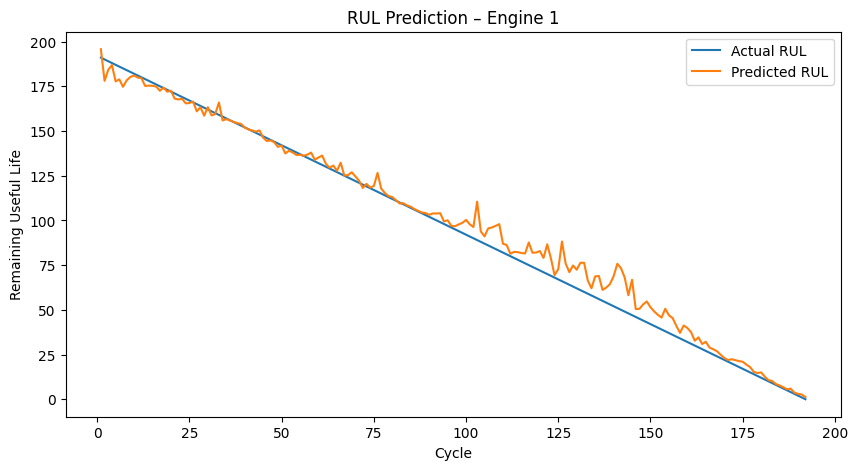

In [98]:
#Visualize actual vs predicted RUL (single engine)

engine_example = rolling_df[rolling_df["engine_id"] == 1]

plt.figure(figsize=(10, 5))
plt.plot(engine_example["cycle"], engine_example["RUL"], label="Actual RUL")
plt.plot(engine_example["cycle"], engine_example["predicted_RUL"], label="Predicted RUL")
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life")
plt.title("RUL Prediction – Engine 1")
plt.legend()
plt.show()


The predicted Remaining Useful Life (RUL) closely follows the actual RUL trajectory throughout the engine lifecycle. Minor deviations reflect sensor noise and modeling uncertainty, particularly during mid-life degradation. The strong alignment near end-of-life indicates that the model effectively captures critical failure behavior, enabling reliable failure horizon estimation under realistic, engine-wise evaluation.

### Anomaly Detection (Early Warning)

In [99]:
# Train Isolation Forest

from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    contamination=0.05,
    random_state=42
)

rolling_df["anomaly"] = iso_forest.fit_predict(rolling_df[roll_cols])


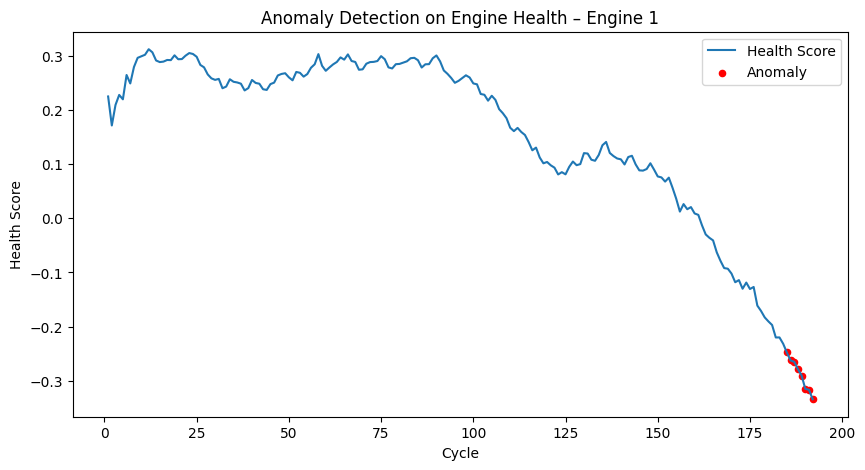

In [100]:
# Visualize anomalies on health score

engine_example = rolling_df[rolling_df["engine_id"] == 1]

plt.figure(figsize=(10, 5))
plt.plot(engine_example["cycle"], engine_example["health_score"], label="Health Score")

anomalies = engine_example[engine_example["anomaly"] == -1]
plt.scatter(
    anomalies["cycle"],
    anomalies["health_score"],
    color="red",
    label="Anomaly",
    s=20
)

plt.xlabel("Cycle")
plt.ylabel("Health Score")
plt.title("Anomaly Detection on Engine Health – Engine 1")
plt.legend()
plt.show()


The anomaly detection results show that abnormal behavior is primarily detected during late-stage degradation, just prior to failure. Early operational cycles remain anomaly-free, confirming that the model learns normal engine behavior. Detected anomalies serve as early warning indicators, complementing RUL prediction by highlighting cycles requiring closer inspection.

## Conclusion

This project developed a complete, end-to-end engine health analytics and predictive maintenance framework using NASA’s CMAPSS turbofan dataset. Raw multivariate time-series sensor data were ingested, cleaned, and analyzed to identify informative degradation signals at both the engine and fleet levels. Sensor variance analysis and temporal smoothing enabled the construction of interpretable health indicators that clearly captured degradation behavior.

Building on this foundation, Remaining Useful Life (RUL) labels were derived, and a regression model was trained using an engine-wise split to ensure realistic generalization to unseen engines. The model successfully tracked degradation trends and provided accurate failure horizon estimates. Additionally, an unsupervised anomaly detection approach identified late-stage abnormal behavior, offering an early warning mechanism complementary to RUL predictions.

Together, these components demonstrate how data-driven health monitoring can support condition-based maintenance, fleet prioritization, and risk-informed decision-making in aerospace systems. Future work includes extending the framework to multiple operating conditions and fault modes (FD002–FD004) and exploring sequence-based deep learning models for enhanced RUL prediction.